This is a binary image classification problem with around 6,000 images scraped from google images. Duplicate images have been removed. Have fun!

https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip gdrive/My\ Drive/Kaggle_Muffin-Chihuahua.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/muffin/img_2_671.jpg  
  inflating: test/muffin/img_2_681.jpg  
  inflating: test/muffin/img_2_689.jpg  
  inflating: test/muffin/img_2_709.jpg  
  inflating: test/muffin/img_2_721.jpg  
  inflating: test/muffin/img_2_73.jpg  
  inflating: test/muffin/img_2_735.jpg  
  inflating: test/muffin/img_2_752.jpg  
  inflating: test/muffin/img_2_757.jpg  
  inflating: test/muffin/img_2_762.jpg  
  inflating: test/muffin/img_2_767.jpg  
  inflating: test/muffin/img_2_78.jpg  
  inflating: test/muffin/img_2_784.jpg  
  inflating: test/muffin/img_2_799.jpg  
  inflating: test/muffin/img_2_8.jpg  
  inflating: test/muffin/img_2_810.jpg  
  inflating: test/muffin/img_2_819.jpg  
  inflating: test/muffin/img_2_82.jpg  
  inflating: test/muffin/img_2_821.jpg  
  inflating: test/muffin/img_2_824.jpg  
  inflating: test/muffin/img_2_827.jpg  
  inflating: test/muffin/img_2_838.jpg  
  inflating: test/muffin/img_2_857.jpg  
  inflating

Text(0.5, 1.0, 'Chihuahua sample')

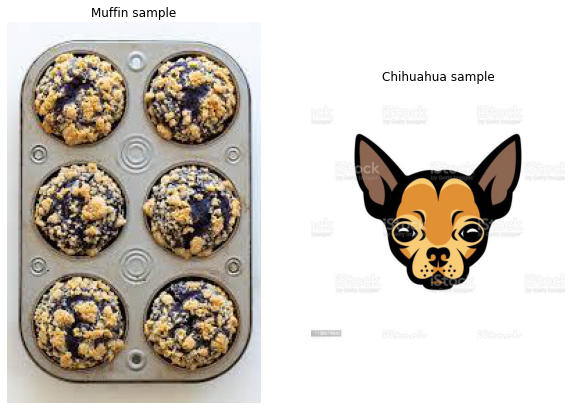

In [4]:
img_sample_muffin = tf.keras.preprocessing.image.load_img('train/muffin/img_0_100.jpg')
img_sample_chihuahua = tf.keras.preprocessing.image.load_img('train/chihuahua/img_0_0.jpg')

fig = plt.figure(figsize=(10,7))
fig.add_subplot(1,2,1)
plt.imshow(img_sample_muffin)
plt.axis('off')
plt.title('Muffin sample')
fig.add_subplot(1,2,2)
plt.imshow(img_sample_chihuahua)
plt.axis('off')
plt.title('Chihuahua sample')

In [5]:
train_dir = '/content/train'
validation_dir = '/content/test'

train_muffin_dir = os.path.join(train_dir, 'muffin')
train_chiuahua_dir = os.path.join(train_dir, 'chihuahua')

validation_muffin_dir = os.path.join(validation_dir, 'muffin')
validation_chihuahua_dir = os.path.join(validation_dir, 'chihuahua')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_muffin_dir))} images of muffin for training.\n")
print(f"There are {len(os.listdir(train_chiuahua_dir))} images of chihuahua for training.\n")
print(f"There are {len(os.listdir(validation_muffin_dir))} images of muffin for validation.\n")
print(f"There are {len(os.listdir(validation_chihuahua_dir))} images of chihuahua for validation.\n")

There are 2174 images of muffin for training.

There are 2559 images of chihuahua for training.

There are 544 images of muffin for validation.

There are 640 images of chihuahua for validation.



In [6]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)


  train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                      batch_size=32, 
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

  validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
                                                                batch_size=32, 
                                                                class_mode='binary',
                                                                target_size=(150, 150))
 
  return train_generator, validation_generator

In [7]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 4733 images belonging to 2 classes.
Found 1184 images belonging to 2 classes.


In [8]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-01-22 21:55:44--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  23.7MB/s    in 4.5s    

2023-01-22 21:55:49 (18.4 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [9]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [10]:
# GRADED FUNCTION: create_pre_trained_model
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [11]:
pre_trained_model = create_pre_trained_model(local_weights_file)

pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [19]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.985):
      print("\nReached 98.5% accuracy so cancelling training!")
      self.model.stop_training = True

In [13]:
def output_of_last_layer(pre_trained_model):

# I chose the last frozen layer mixed7

  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [14]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [15]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [16]:
def create_final_model(pre_trained_model, last_output):

  x = layers.Flatten()(last_output)

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation = 'relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(0.2)(x) 
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)        

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [17]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [20]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100

Reached 98.5% accuracy so cancelling training!
148/148 - 79s - loss: 0.0574 - accuracy: 0.9852 - val_loss: 0.0570 - val_accuracy: 0.9890 - 79s/epoch - 533ms/step


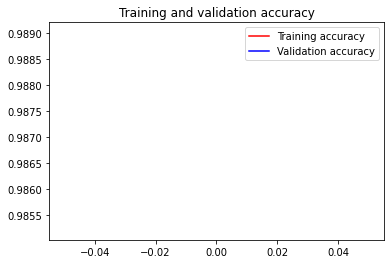

<Figure size 432x288 with 0 Axes>

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()